## Import modules

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scrublet as scr
import session_info

In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')
session_info.show()

## Functions

## Read in anndata

In [4]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/QC/multiome_RNA_foetal_prefilter.h5ad')
adata

AnnData object with n_obs × n_vars = 721979 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-16', 'ambient_expression-17', 'ambient_expression-18', 'ambient_expression-19', 'ambient_expression-2', 'ambient_expression-20', 'ambient_expression-21', 'ambient_expression-22', 'ambient_expression-23', 'ambient_expression-24', 'ambient_expression-25', 'ambient_expression-26', 'ambient_expression-27', 'ambient_expression-28', 'ambient_expression-29', 'ambient

In [5]:
adata.obs['combinedID'].value_counts()

BHF_F_Hea13188316_BHF_F_Hea13187618      59866
7089STDY13216924_BHF_F_Hea13242531       40000
BHF_F_Hea11933665_BHF_F_Hea11596618      33997
7089STDY13216925_BHF_F_Hea13242532       30453
BHF_F_Hea13188318_BHF_F_Hea13187620      27856
7089STDY13216920_BHF_F_Hea13242527       27498
BHF_F_Hea13168898_BHF_F_Hea13168514      24781
7089STDY13216927_BHF_F_Hea13242534       24666
7089STDY13216926_BHF_F_Hea13242533       24602
BHF_F_Hea13188324_BHF_F_Hea13187626      24381
7089STDY13216921_BHF_F_Hea13242528       24211
BHF_F_Hea13168896_BHF_F_Hea13168512      22267
HCAHeartST13386009_HCAHeartST13303419    21577
BHF_F_Hea11933666_BHF_F_Hea11596619      21509
BHF_F_Hea13168899_BHF_F_Hea13168515      21418
7089STDY13216922_BHF_F_Hea13242529       21402
BHF_F_Hea13188317_BHF_F_Hea13187619      21327
BHF_F_Hea11933664_BHF_F_Hea11596617      20338
BHF_F_Hea11933667_BHF_F_Hea11596620      19811
BHF_F_Hea13168894_BHF_F_Hea13168510      19258
BHF_F_Hea11933669_BHF_F_Hea11596622      19029
BHF_F_Hea1316

## Remove doublets

<AxesSubplot:>

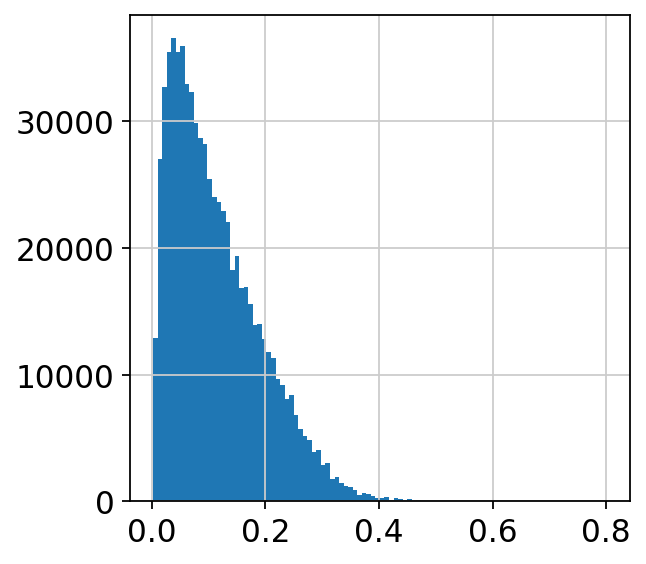

In [6]:
adata.obs['scrublet_score'].hist(bins=100)

In [7]:
# set threshold (arbitrary)
dbl_score_thresh=0.15

prop = np.sum(adata.obs['scrublet_score']>=dbl_score_thresh)/len(adata)
print(f'proportion of doublets: {prop}')

proportion of doublets: 0.2872091847546812


In [8]:
# Save doublet ids
doublets = adata.obs_names[(adata.obs['scrublet_score']<dbl_score_thresh)==False]
with open('/nfs/team205/heart/anndata_objects/Foetal/QC/Multiome_rm-doublets.txt', 'w') as f:
    for line in doublets:
        f.write(line)
        f.write('\n')

# Remove doublets
adata = adata[adata.obs['scrublet_score']<dbl_score_thresh]
print(adata.shape)

(514620, 36601)


## Remove low quality cells

In [9]:
sc.pp.filter_cells(adata, min_genes=500, inplace=True)
sc.pp.filter_cells(adata, min_counts=1000, inplace=True)
adata.shape

filtered out 73084 cells that have less than 500 genes expressed
Trying to set attribute `.obs` of view, copying.
filtered out 41920 cells that have less than 1000 counts


(399616, 36601)

## Compute QC stats

In [10]:
adata.var['mt'] = adata.var['gene_name'].str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var['gene_name'].str.startswith('RPS','RPL')  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=True, inplace=True)

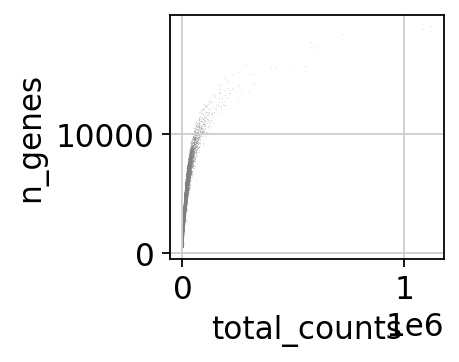

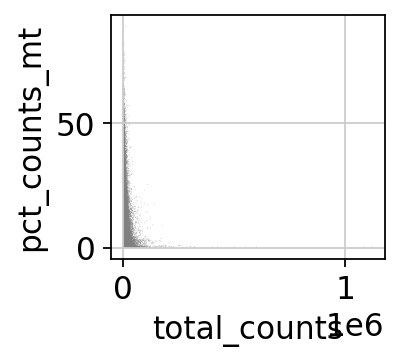

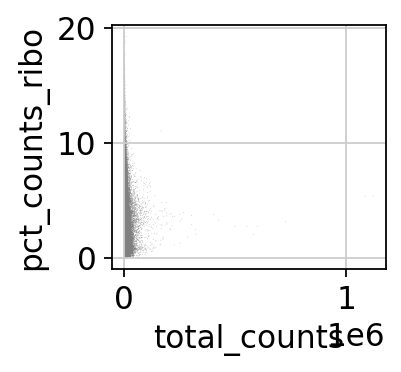

In [11]:
plt.rcParams['figure.figsize'] = [3, 2]

sc.pl.scatter(adata, x='total_counts', y='n_genes')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo')

## Remove cells exceeding the ribo/mito threshold

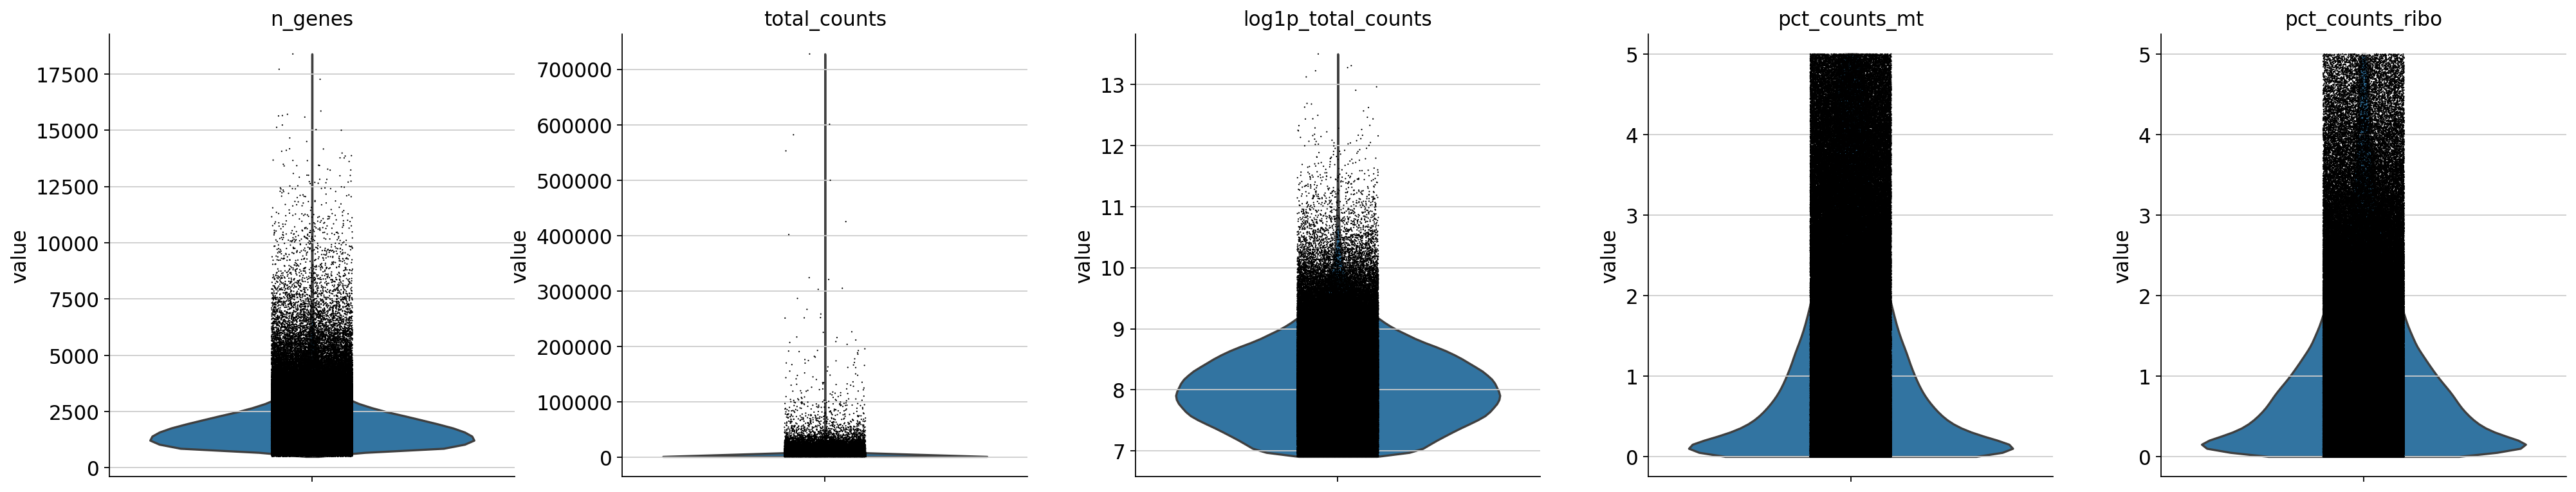

In [12]:
plt.rcParams['figure.figsize'] = [2, 2]
adata = adata[adata.obs['pct_counts_mt'] < 5, :]
adata = adata[adata.obs['pct_counts_ribo'] < 5, :]
sc.pl.violin(adata, ['n_genes', 'total_counts', 'log1p_total_counts','pct_counts_mt', 'pct_counts_ribo'],jitter = 0.1, multi_panel = True)

Trying to set attribute `.uns` of view, copying.


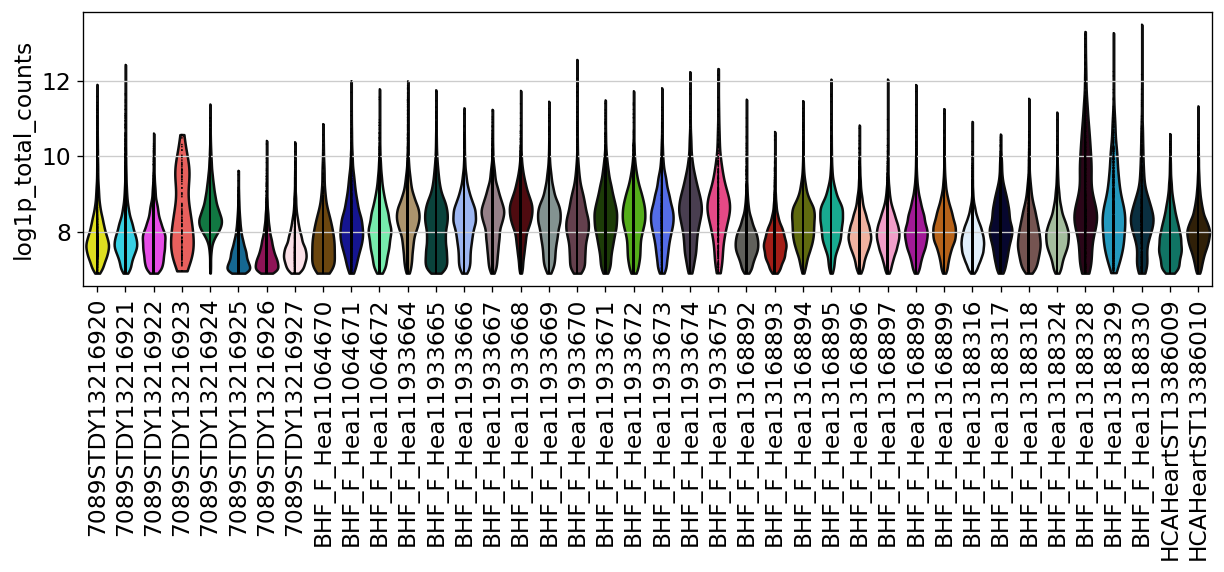

In [13]:
sc.settings.set_figure_params(dpi = 120, color_map = 'RdPu')
plt.rcParams['figure.figsize'] = 10,3
sc.pl.violin(adata,keys=['log1p_total_counts'],groupby='sangerID',rotation=90,jitter=False)

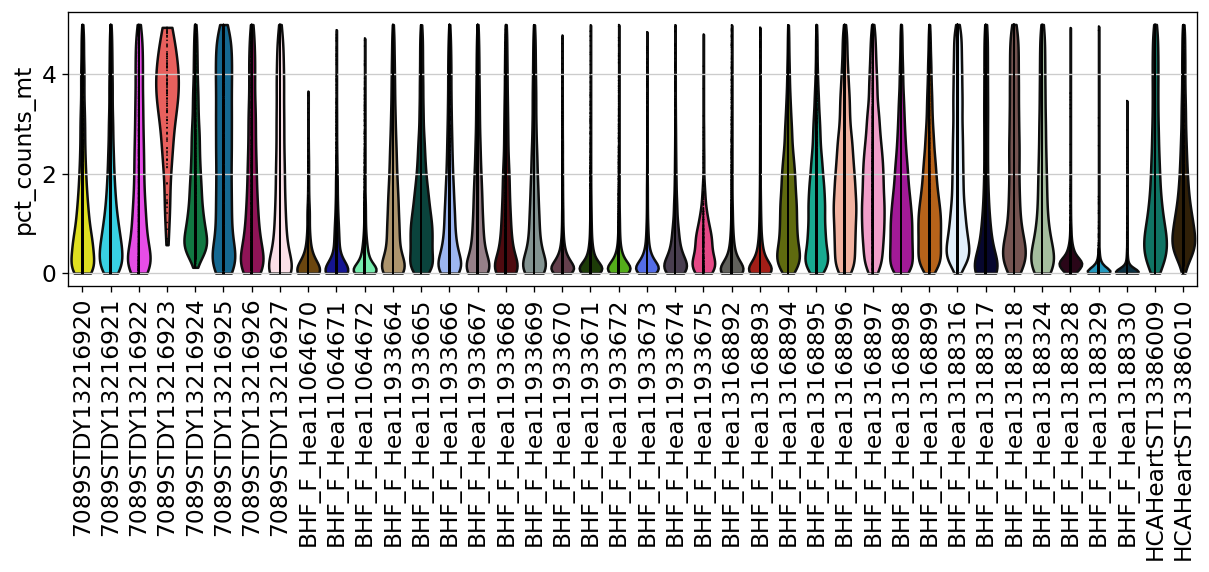

In [14]:
plt.rcParams['figure.figsize'] = 10,3
sc.pl.violin(adata,keys=['pct_counts_mt'],groupby='sangerID',rotation=90,jitter=False)

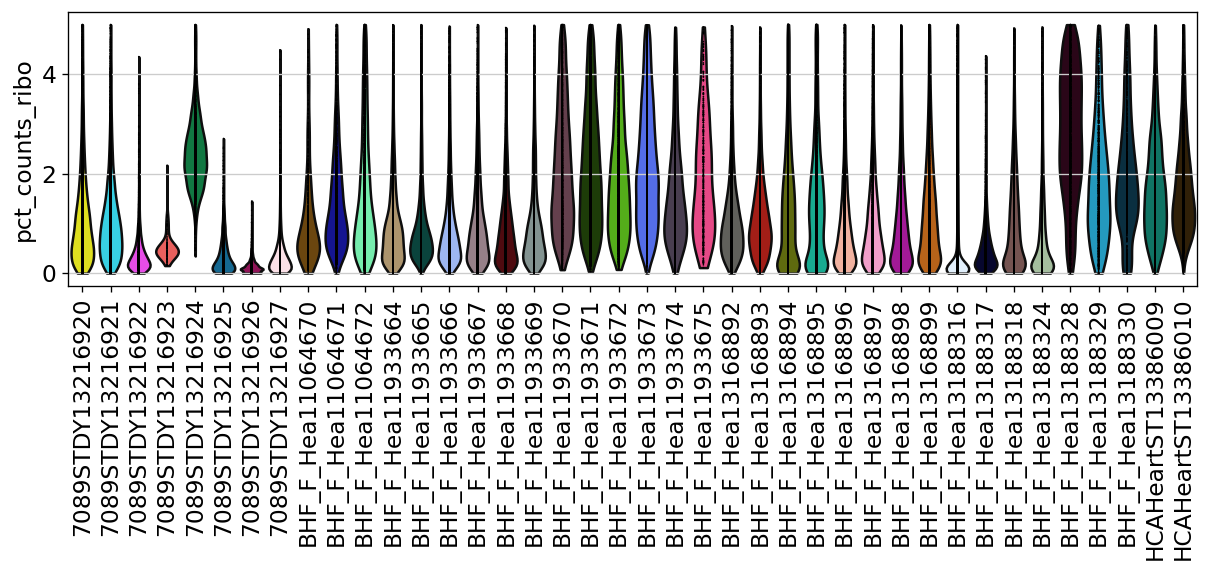

In [15]:
plt.rcParams['figure.figsize'] = 10,3
sc.pl.violin(adata,keys=['pct_counts_ribo'],groupby='sangerID',rotation=90,jitter=False)

In [16]:
sc.settings.set_figure_params(dpi = 120, color_map = 'RdPu')

In [17]:
adata.shape

(285185, 36601)

## Calculate RBC score 

In [18]:
adata_c = adata.copy()

adata_c.var.set_index('gene_name',inplace=True)
adata_c.var_names = adata_c.var_names.astype('str')
adata_c.var_names_make_unique()

sc.pp.filter_genes(adata_c, min_cells=3)
sc.pp.normalize_total(adata_c, target_sum=1e4)
sc.pp.log1p(adata_c)

filtered out 2031 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:02)


In [19]:
# scoring hemoglobin genes
# HGNC, Hemoglobin subunits, groupID:940
genes=['HBA1','HBA2','HBB','HBD','HBE1','HBG1','HBG2','HBM','HBQ1','HBZ']
sc.tl.score_genes(adata_c,gene_list=genes,score_name='HB_score')

computing score 'HB_score'
    finished: added
    'HB_score', score of gene set (adata.obs).
    399 total control genes are used. (0:00:10)


In [20]:
len(adata_c.obs['sangerID'].unique())

40

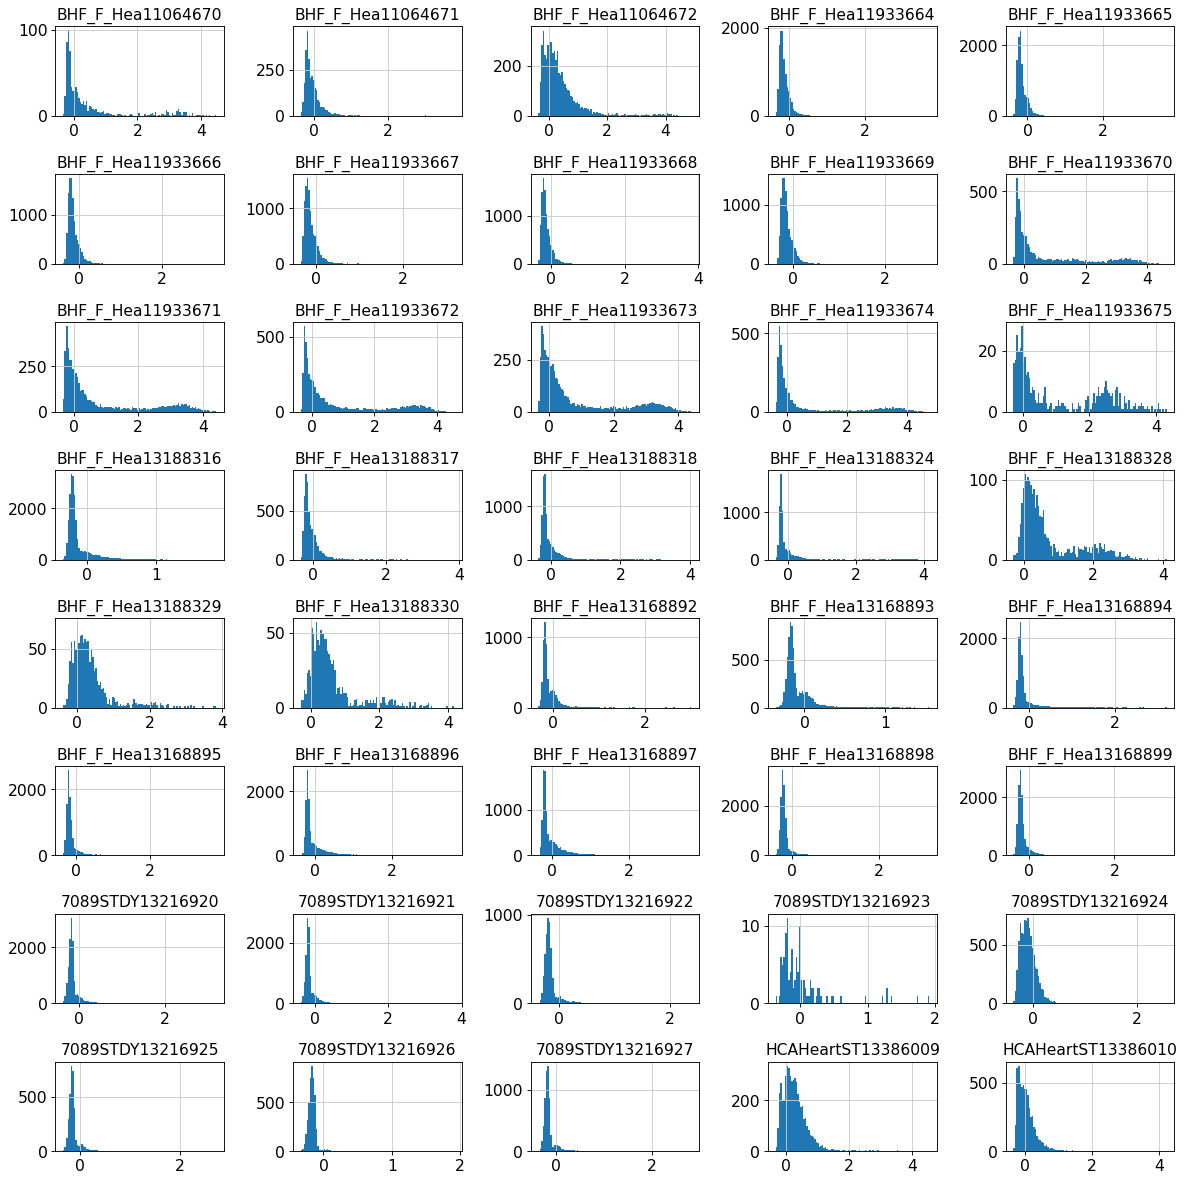

In [21]:
sc.settings.set_figure_params(dpi = 80, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

fig,axs=plt.subplots(nrows=8,ncols=5,figsize=(15,15))

for i,ID in enumerate(adata_c.obs['sangerID'].unique()):
    sample = adata_c[adata_c.obs['sangerID']==ID]
    axs[i//5,i%5].hist(sample.obs['HB_score'],bins=100)
    axs[i//5,i%5].set_title(ID)

fig.tight_layout()
plt.show()

In [22]:
# add HB score to original adata
adata.obs.loc[adata_c.obs_names,'HB_score']=adata_c.obs['HB_score']

## Remove RBCs

In [23]:
HBscore_thresh=1

adata=adata[adata.obs['HB_score']<HBscore_thresh]
print(adata.shape)

(274033, 36601)


In [24]:
adata.obs['combinedID'].value_counts()

BHF_F_Hea13188316_BHF_F_Hea13187618      21518
BHF_F_Hea13168898_BHF_F_Hea13168514      13895
7089STDY13216920_BHF_F_Hea13242527       12771
BHF_F_Hea13168899_BHF_F_Hea13168515      12369
BHF_F_Hea11933665_BHF_F_Hea11596618      11830
BHF_F_Hea13168896_BHF_F_Hea13168512      11191
BHF_F_Hea11933664_BHF_F_Hea11596617      11022
7089STDY13216921_BHF_F_Hea13242528       10826
BHF_F_Hea11933666_BHF_F_Hea11596619      10463
BHF_F_Hea11933667_BHF_F_Hea11596620      10340
BHF_F_Hea13168894_BHF_F_Hea13168510       9994
BHF_F_Hea11933669_BHF_F_Hea11596622       9539
BHF_F_Hea11933668_BHF_F_Hea11596621       9490
BHF_F_Hea13168895_BHF_F_Hea13168511       9431
BHF_F_Hea13168897_BHF_F_Hea13168513       9315
7089STDY13216924_BHF_F_Hea13242531        8598
BHF_F_Hea13188318_BHF_F_Hea13187620       7474
BHF_F_Hea13168893_BHF_F_Hea13168509       6747
BHF_F_Hea13188324_BHF_F_Hea13187626       6266
7089STDY13216927_BHF_F_Hea13242534        6061
HCAHeartST13386010_HCAHeartST13303420     6015
BHF_F_Hea1316

## Remove donor-unassigned nuclei in multiplexed samples

In [27]:
# read in SOC-CMO result
demul = pd.read_csv('/nfs/team205/heart/mapped/cellranger-arc200/SOC_out/SOC-CMO-assignment_multiome-foetal_20230207.csv',
                   index_col=0)
print(demul.shape)
print(demul['SOC-CMO_assignment'].value_counts())
demul.head()

(74984, 4)
Hst39               36363
Hst40               21936
donor_unassigned    11437
Hst36                5248
Name: SOC-CMO_assignment, dtype: int64


,SOC | status,SOC | log_prob_singleton,SOC | log_prob_doublet,SOC-CMO_assignment
obsnames,,,,
7089STDY13216920_BHF_F_Hea13242527_GCCCTCATCCTAGTAA-1,singlet,-1804.326000,-2214.313429,Hst40
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1,singlet,-2300.029401,-2917.765214,Hst39
7089STDY13216920_BHF_F_Hea13242527_TGGTCCTTCCGTGACA-1,singlet,-7138.100603,-8752.227197,Hst39
7089STDY13216920_BHF_F_Hea13242527_TTCAGTTTCCGCTAGA-1,singlet,-16501.683493,-20232.559001,Hst40
7089STDY13216920_BHF_F_Hea13242527_GTCAATATCATCCACC-1,singlet,-15506.974212,-16020.863109,Hst39


In [28]:
# just checking
# multiplexed samples which passed through QC-filtering above
multiplex_obsnames = adata.obs_names[adata.obs['combinedID'].isin(['7089STDY13216920_BHF_F_Hea13242527',
                                                                   '7089STDY13216921_BHF_F_Hea13242528',
                                                                   '7089STDY13216922_BHF_F_Hea13242529',
                                                                   '7089STDY13216923_BHF_F_Hea13242530'])]
print(demul.loc[multiplex_obsnames].shape)
print(demul.loc[multiplex_obsnames]['SOC-CMO_assignment'].value_counts())

# make 'donor_by_libraryprep' column
adata.obs['donor_by_library-prep'] = adata.obs['donor'].copy()
# make 'multiplexed' column
adata.obs['multiplexed'] = 'No'
adata.obs.loc[multiplex_obsnames,'multiplexed'] = 'Yes'

# replace 'donor' column for multiplexed samples
adata.obs['donor'] = adata.obs['donor'].astype('str')
adata.obs.loc[multiplex_obsnames,'donor'] = demul.loc[multiplex_obsnames,'SOC-CMO_assignment']

# add some SOC metrices
cols_to_add = ['SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet']
adata.obs[cols_to_add] = demul[cols_to_add].loc[multiplex_obsnames].reindex(adata.obs_names)

# check
print(adata.obs.loc[multiplex_obsnames]['donor'].value_counts())
print(adata.shape)

Trying to set attribute `.obs` of view, copying.


(29085, 4)
Hst39               17519
Hst40                8084
Hst36                1787
donor_unassigned     1695
Name: SOC-CMO_assignment, dtype: int64
Hst39               17519
Hst40                8084
Hst36                1787
donor_unassigned     1695
Name: donor, dtype: int64
(274033, 36601)


In [29]:
# remove unassigned nuclei
adata = adata[adata.obs['donor'] != 'donor_unassigned']
print(adata.shape)

(272338, 36601)


## Update metadata for the multiplexed samples

In [30]:
# to see which column needs to be updated
adata.obs[adata.obs['multiplexed']=='Yes'][['sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender']].head(n=3)

,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender
barcode,,,,,,,,
7089STDY13216920_BHF_F_Hea13242527_ACTCGCTTCCTAGTAA-1,7089STDY13216920,7089STDY13216920_BHF_F_Hea13242527,Hst39,na,"Aorta (Hst39), Nodes (Hst40)","Aorta (Hst39), Nodes (Hst40)",multiplexed,multiplexed
7089STDY13216920_BHF_F_Hea13242527_TATAACCCAAACGGGC-1,7089STDY13216920,7089STDY13216920_BHF_F_Hea13242527,Hst39,na,"Aorta (Hst39), Nodes (Hst40)","Aorta (Hst39), Nodes (Hst40)",multiplexed,multiplexed
7089STDY13216920_BHF_F_Hea13242527_ACGTCAAGTGGAGCAA-1,7089STDY13216920,7089STDY13216920_BHF_F_Hea13242527,Hst39,na,"Aorta (Hst39), Nodes (Hst40)","Aorta (Hst39), Nodes (Hst40)",multiplexed,multiplexed


In [31]:
adata.obs[adata.obs['multiplexed']=='Yes'][['sangerID','donor','region']].value_counts()

sangerID          donor  region                                                       
7089STDY13216920  Hst39  Aorta (Hst39), Nodes (Hst40)                                     8819
7089STDY13216921  Hst39  Aorta (Hst39), Nodes (Hst40)                                     7402
7089STDY13216920  Hst40  Aorta (Hst39), Nodes (Hst40)                                     3321
7089STDY13216921  Hst40  Aorta (Hst39), Nodes (Hst40)                                     2934
7089STDY13216922  Hst40  Heart (Hst36), Heart-wo-nodes (Hst39), Heart-wo-nodes (Hst40)    1828
                  Hst36  Heart (Hst36), Heart-wo-nodes (Hst39), Heart-wo-nodes (Hst40)    1786
                  Hst39  Heart (Hst36), Heart-wo-nodes (Hst39), Heart-wo-nodes (Hst40)    1298
7089STDY13216923  Hst40  Heart (Hst36), Heart-wo-nodes (Hst39), Heart-wo-nodes (Hst40)       1
                  Hst36  Heart (Hst36), Heart-wo-nodes (Hst39), Heart-wo-nodes (Hst40)       1
dtype: int64

In [32]:
# prepare metadata dictionary
age_gender = {
    'Hst36': ['PCW-12w','Female'],
    'Hst39': ['PCW-15w','Female'],
    'Hst40': ['PCW-14w','Male'],
}

regions = {
    '7089STDY13216920_Hst39':'Aorta',
    '7089STDY13216920_Hst40':'Nodes',
    '7089STDY13216921_Hst39':'Aorta',
    '7089STDY13216921_Hst40':'Nodes',
    '7089STDY13216922_Hst36':'Heart',
    '7089STDY13216922_Hst39':'Heart-wo-nodes',
    '7089STDY13216922_Hst40':'Heart-wo-nodes',
    '7089STDY13216923_Hst36':'Heart',
    '7089STDY13216923_Hst39':'Heart-wo-nodes',
    '7089STDY13216923_Hst40':'Heart-wo-nodes',
}

In [33]:
# update
SangerIDs = list(set(adata.obs[adata.obs['multiplexed']=='Yes']['sangerID']))
Donors = list(set(adata.obs[adata.obs['multiplexed']=='Yes']['donor']))

for sID in SangerIDs:
    for d in Donors:
        obsnames_to_update = adata.obs_names[(adata.obs['sangerID']==sID)&(adata.obs['donor']==d)]
        print(f'{sID}, {d}: {len(obsnames_to_update)} nuclei')
        # update
        if len(obsnames_to_update)>0:
            adata.obs.loc[obsnames_to_update,'region'] = regions[f'{sID}_{d}']
            adata.obs.loc[obsnames_to_update,'region_finest'] = regions[f'{sID}_{d}']
            adata.obs.loc[obsnames_to_update,'age'] = age_gender[d][0]
            adata.obs.loc[obsnames_to_update,'gender'] = age_gender[d][1]
        else:
            pass
        del obsnames_to_update

7089STDY13216921, Hst36: 0 nuclei
7089STDY13216921, Hst40: 2934 nuclei
7089STDY13216921, Hst39: 7402 nuclei
7089STDY13216922, Hst36: 1786 nuclei
7089STDY13216922, Hst40: 1828 nuclei
7089STDY13216922, Hst39: 1298 nuclei
7089STDY13216923, Hst36: 1 nuclei
7089STDY13216923, Hst40: 1 nuclei
7089STDY13216923, Hst39: 0 nuclei
7089STDY13216920, Hst36: 0 nuclei
7089STDY13216920, Hst40: 3321 nuclei
7089STDY13216920, Hst39: 8819 nuclei


## Save post-filtered anndata

In [34]:
# save
adata.write('/nfs/team205/heart/anndata_objects/Foetal/QC/multiome_RNA_foetal.h5ad')
adata

/opt/conda/envs/teichlab/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'donor' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'multiplexed' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'SOC | status' as categorical


AnnData object with n_obs × n_vars = 272338 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-16'

## Just checking

In [35]:
adata.obs['combinedID'].value_counts()

BHF_F_Hea13188316_BHF_F_Hea13187618      21518
BHF_F_Hea13168898_BHF_F_Hea13168514      13895
BHF_F_Hea13168899_BHF_F_Hea13168515      12369
7089STDY13216920_BHF_F_Hea13242527       12140
BHF_F_Hea11933665_BHF_F_Hea11596618      11830
BHF_F_Hea13168896_BHF_F_Hea13168512      11191
BHF_F_Hea11933664_BHF_F_Hea11596617      11022
BHF_F_Hea11933666_BHF_F_Hea11596619      10463
BHF_F_Hea11933667_BHF_F_Hea11596620      10340
7089STDY13216921_BHF_F_Hea13242528       10336
BHF_F_Hea13168894_BHF_F_Hea13168510       9994
BHF_F_Hea11933669_BHF_F_Hea11596622       9539
BHF_F_Hea11933668_BHF_F_Hea11596621       9490
BHF_F_Hea13168895_BHF_F_Hea13168511       9431
BHF_F_Hea13168897_BHF_F_Hea13168513       9315
7089STDY13216924_BHF_F_Hea13242531        8598
BHF_F_Hea13188318_BHF_F_Hea13187620       7474
BHF_F_Hea13168893_BHF_F_Hea13168509       6747
BHF_F_Hea13188324_BHF_F_Hea13187626       6266
7089STDY13216927_BHF_F_Hea13242534        6061
HCAHeartST13386010_HCAHeartST13303420     6015
BHF_F_Hea1316

In [36]:
adata.obs['donor'].value_counts()

Hst41    129909
Hst33     62684
Hst39     30591
C92       15379
Hst40     11559
Hst36      7848
C87        4499
C104       3411
C98        3039
C85        2808
C82         611
Name: donor, dtype: int64

In [37]:
pd.crosstab(adata.obs['donor'],adata.obs['age'])

age,GA-6w3d,GA-7w4d,GA-9w,GA-10w4d,GA-11w2d,GA-11w3d,PCW-12w,PCW-13w,PCW-14w,PCW-15w,PCW-20w
donor,,,,,,,,,,,
C82,0,0,0,0,0,611,0,0,0,0,0
C85,0,0,0,0,2808,0,0,0,0,0,0
C87,0,0,0,4499,0,0,0,0,0,0,0
C92,0,15379,0,0,0,0,0,0,0,0,0
C98,0,0,3039,0,0,0,0,0,0,0,0
C104,3411,0,0,0,0,0,0,0,0,0,0
Hst33,0,0,0,0,0,0,0,62684,0,0,0
Hst36,0,0,0,0,0,0,7848,0,0,0,0
Hst39,0,0,0,0,0,0,0,0,0,30591,0


In [38]:
pd.crosstab(adata.obs['donor'],adata.obs['gender'])

gender,Female,Male,na
donor,,,
C82,0,0,611
C85,0,0,2808
C87,0,0,4499
C92,0,0,15379
C98,0,0,3039
C104,0,0,3411
Hst33,0,0,62684
Hst36,7848,0,0
Hst39,30591,0,0


In [39]:
adata.obs['SOC | status'].value_counts()

nan           244948
singlet        27068
doublet          246
unassigned        76
Name: SOC | status, dtype: int64

In [40]:
adata.obs[adata.obs['multiplexed']=='Yes']['donor_by_library-prep'].value_counts()

Hst39, Hst40           22476
Hst36, Hst39, Hst40     4914
Hst41                      0
Hst40                      0
Hst39                      0
Hst36                      0
Hst33                      0
C104                       0
C98                        0
C92                        0
C87                        0
C85                        0
C82                        0
Name: donor_by_library-prep, dtype: int64